### Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# import datapane as dp
import pygam

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# enter your path to the datasets here!
path = 'data/Bike-Sharing-Dataset/hour.csv' 
tl_path = 'data/timeseries.csv'
stays_path = 'data/stays.csv'

### Load Data

In [28]:
from tqdm import tqdm
from collections import defaultdict
import re
import pickle

motors = ['Localizes Pain', 'Flex-withdraws', 'Obeys Commands',
       'No Response', 'Abnorm extensn', 'Abnorm flexion']
verbals = ['Confused', 'Inapprop words', 'ET/Trach', 'Oriented',
       'Incomp sounds']
eye = ['To speech', 'To pain', 'Spontaneously', 'No Response']

motors = [re.compile(suffix) for suffix in motors]
verbals = [re.compile(suffix) for suffix in verbals]
eye = [re.compile(suffix) for suffix in eye]

replace_dict = {
    'Glascow coma scale eye opening':eye, 
    'Glascow coma scale motor response':motors, 
    'Glascow coma scale verbal response':verbals
}

def remove_suffixes(s, patterns):
    for pattern in patterns:
        s = pattern.sub("", s)
    return int(eval(s))

def reshape_window(window, window_size):
    '''
    Takes a timeline window and does the following transformations
    
    1. Removes unnecessary cols
    2. input df is of shape [window_size, (n_features+n_drop_cols+1)]
        reshapes this into [1, (window_size*n_features)]
    '''

    drop_cols = ['Temperature', 'SUBJECT_ID', 'Hours']
    
    window['timesteps'] = range(window_size)
    window = window.drop(drop_cols, axis=1)

    window_melt = window.melt(id_vars=['timesteps']).sort_values(['timesteps', 'variable'])
    
    # In this step we are joining two melted cols together and making it index 
    window_melt['feature'] = window_melt.apply(lambda x: x['variable'] + '_' + str(x['timesteps']), axis=1)
    window_melt = window_melt.drop(['variable', 'timesteps'], axis=1)[['feature', 'value']]

    # Finally transposing that the shape becomes [1, (window_size*n_features)] instead of 
    # [(window_size*n_features), 1]
    window_reshaped = window_melt.set_index('feature').transpose()
    
    return window_reshaped

select_cols = ['Hours', 'Diastolic blood pressure',
       'Fraction inspired oxygen', 'Glascow coma scale eye opening',
       'Glascow coma scale motor response', 'Glascow coma scale total',
       'Glascow coma scale verbal response', 'Glucose', 'Heart Rate',
       'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate',
       'Systolic blood pressure', 'Temperature', 'SUBJECT_ID']

# A function to get mortality status of the subject from stays dataframe
get_mortality_status =  lambda subj_id: stays[stays.SUBJECT_ID==subj_id].MORTALITY.values[0] \
                                if ((stays[stays.SUBJECT_ID==subj_id].MORTALITY.values==0) |\
                                    (stays[stays.SUBJECT_ID==subj_id].MORTALITY.values==1)) \
                                else None

def load_dataframes():

    print('Loading dataframes')
    # Loading dataframes
    tl = pd.read_csv(tl_path)
    stays = pd.read_csv(stays_path)
    tl = tl[select_cols]


    print('Replacing GCS..')
    for name, replace_ls in replace_dict.items():

        tl[name] = tl[name].apply(lambda x: remove_suffixes(x, replace_ls))
        
    return tl, stays


def generate_data_dict(timeline_df, window_size=12):

    # Creating group dictionary
    group_dict = {subj_id:timeline for subj_id, timeline in tl.groupby('SUBJECT_ID')}

    data_dict = {} # Dictionary to store all data

    print('Transforming..')
    for subj_id, timeline in tqdm(group_dict.items()): # Processing individual timelines

        subj_dict = defaultdict(list) # Another dict thats provided as value to the data_dict

        mortality_status = get_mortality_status(subj_id)

        # Ignoring invalid inputs

        if len(timeline)<window_size: 
            continue

        if mortality_status==None:
            continue

        # Breaking timelines to individual windows of a single 
        # timestep progression

        for i in range(len(timeline)):

            window_end = window_size+i

            if window_end<len(timeline):

                window = timeline.iloc[i:window_end]
                subj_dict['window'].append(reshape_window(window, window_size))

                if (window_end==len(timeline)-1):

                    subj_dict['target'].append(mortality_status)

                else:

                    subj_dict['target'].append(0)

        if subj_dict.get('window'):
            windows_df = pd.concat(subj_dict.get('window'))
            subj_dict['window'] = windows_df

            data_dict[subj_id] = subj_dict
    
    print('Storing data_dict in data folder..')
    with open('data/data_dict.pkl', 'wb') as file:
        pickle.dump(data_dict, file)
            
    return data_dict

In [106]:
import random

split_ratio = 0.7
random_seed = 123

def train_test_split(data_dict, split_ratio=0.7, random_seed=123):

    subj_ids = list(data_dict.keys())
    random.Random(random_seed).shuffle(subj_ids)
    print(f"Random seed: {random_seed}")
    print(f"Split ratio: {split_ratio}")

    split_index = round(len(subj_ids)*split_ratio)

    train_samples = subj_ids[:split_index]
    test_samples = subj_ids[split_index:]

    X_train, y_train = get_arrays(data_dict, train_samples)
    X_test, y_test = get_arrays(data_dict, test_samples)
    
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    final_split_ratio = train_size/(train_size+test_size)

    print(f"""Completed train test split.. Train size: {train_size} Test size: {test_size} 
        Final split ratio: {final_split_ratio}""")
    
    return X_train, X_test, y_train, y_test

def get_arrays(data_dict, subset):

    windows = [data_dict.get(sample).get('window') for sample in subset]
    targets = [data_dict.get(sample).get('target') for sample in subset]

    concat_df = pd.concat(windows)
    targets = [t for sublist in targets for t in sublist]

    X = concat_df.values
    y = np.array(targets)
    
    return X, y

In [27]:
tl, stays = load_dataframes()
generate_data_dict(tl)

X_train, X_test, y_train, y_test = train_test_split(data_dict)

In [116]:
from pygam import LogisticGAM

log_gam = LogisticGAM(n_splines=10).gridsearch(X_train, y_train)

In [ ]:
log_gam.accuracy(X_test, y_test)

# Bike rides sample

In [108]:
df = pd.read_csv(path)
df.drop(['instant','casual','registered'],axis=1,inplace=True)
df.columns =['date','season','year','month','hour','is_holiday','weekday','is_workingday','weather','temp','temp_feel','humidity','wind','total']
df.head(3)

,date,season,year,month,hour,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humidity,wind,total
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32


In [109]:
df.describe()

,season,year,month,hour,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humidity,wind,total
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [110]:
df['highlow'] = df.total.apply(lambda x: 1 if x>142 else 0)

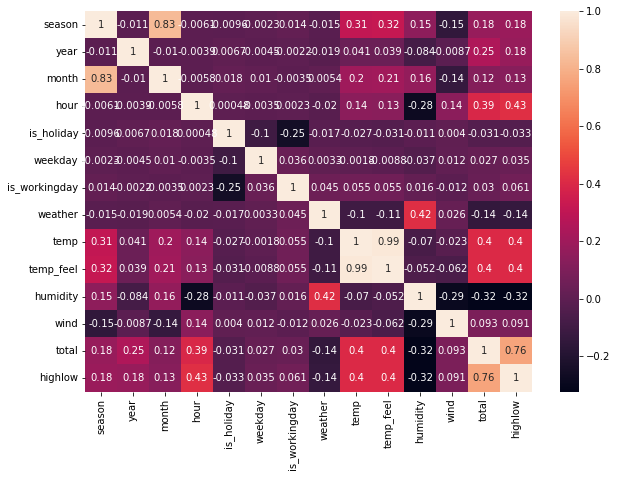

In [111]:
fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap(df.corr(),annot=True);

In [112]:
# drop the id column
df = df.drop(['date', 'total'],axis=1)

# encode the diagnosis column
df_X = df.drop(['highlow'], axis=1).values
df_y = df['highlow']

In [147]:
from pygam import LogisticGAM

log_gam = LogisticGAM(n_splines=10).gridsearch(df_X, df_y)

100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


In [148]:
log_gam.accuracy(df_X, df_y)

0.8848034984751711

In [151]:
len(df.columns[:-1])

12

<Figure size 864x576 with 0 Axes>

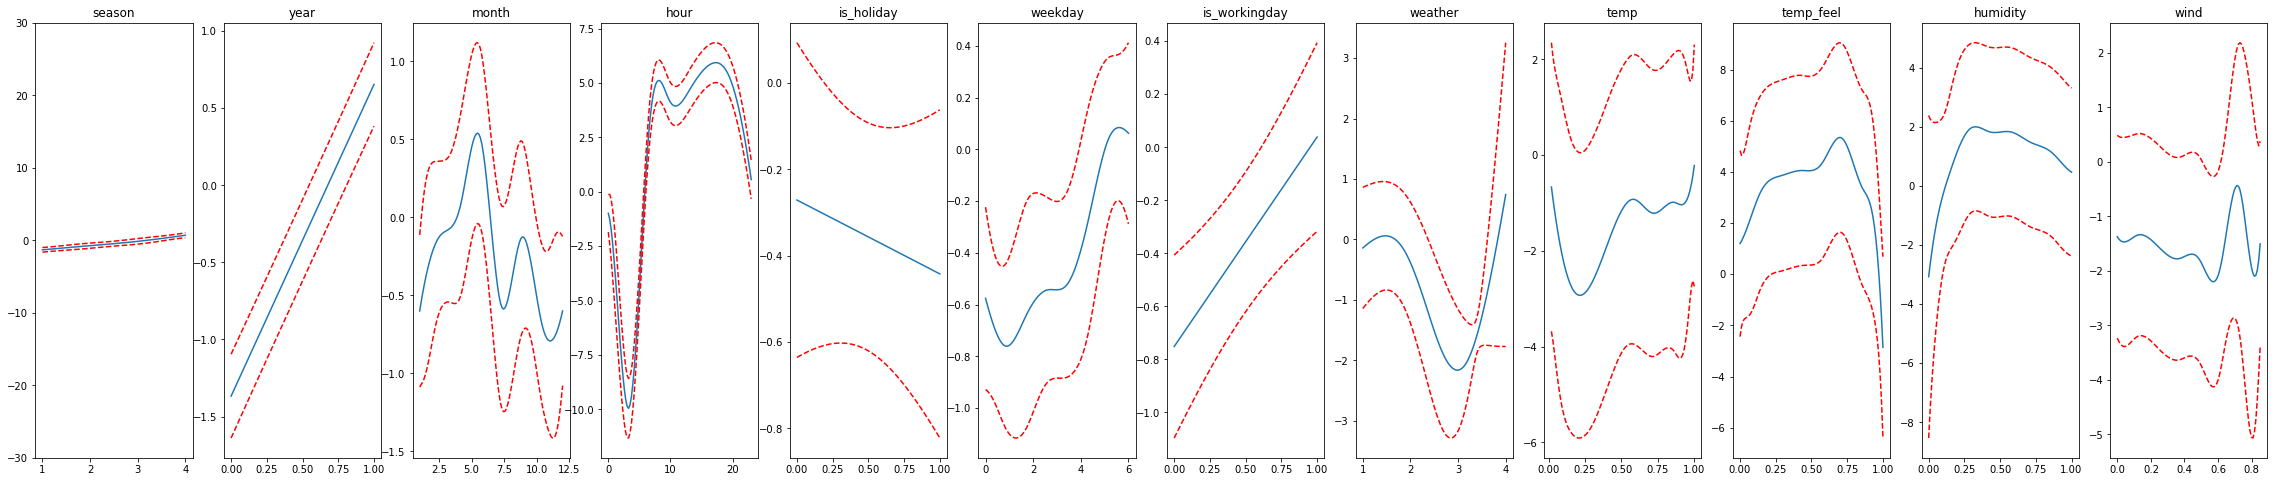

In [155]:
titles = df.columns[:-1]
plt.figure()
fig, axs = plt.subplots(1,len(titles),figsize=(40, 8))
for i, ax in enumerate(axs):
    XX = log_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

plt.savefig('trial.jpg')

In [108]:
def plot_col(col):

    median_df = df[[col,'total']].groupby(col).median().reset_index()

    plot = px.scatter(data_frame=median_df,
                      x=col,
                      y='total',
                      title=f'Median Bike Rentals Per {col.title()}')
    plot.data[0].update(mode='markers+lines')
    plot.update_layout(xaxis={'dtick':1},showlegend=True)
    # report = dp.Report(dp.Plot(plot))
    # report.publish(name='Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
    
    return plot

col = 'season'
plot = plot_col(col)
plot

In [105]:
median_df = df[[col,'total']].groupby(col).median().reset_index()

### Linear Regression

In [107]:
def plot_preds(col):

    model=LinearRegression()
    model.fit(median_df[[col]],median_df['total'])
    median_df['Linear Regression'] = model.predict(median_df[[col]])

    plot = px.scatter(data_frame=median_df,
                      x=col,
                      y=['total','Linear Regression'],title=f'Linear Regression for Median Bike Rentals Per {col.title()}')

    plot.data[0].update(mode='markers+lines')
    plot.data[1].update(mode='markers+lines')
    plot.update_layout(xaxis={'dtick':1},showlegend=True,
                       legend=dict(
                                    orientation="h",
                                    yanchor="bottom",
                                    xanchor="right",x=.3,y=-.3))
    
    return plot

# dp.Report(dp.Plot(plot)).publish(name='Linear Regression for Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
plot = plot_preds(col)
plot

In [109]:
poly = PolynomialFeatures(30)
poly_df = pd.DataFrame(poly.fit_transform(median_df[[col]]),columns = poly.get_feature_names())
poly_df.head(2)

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,1,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,...,x0^21,x0^22,x0^23,x0^24,x0^25,x0^26,x0^27,x0^28,x0^29,x0^30
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000e+00
1,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,...,2097152.0,4194304.0,8388608.0,16777216.0,33554432.0,67108864.0,134217728.0,268435456.0,536870912.0,1.073742e+09


In [110]:
vals = [1,3,5,10]
vals_col = []

In [111]:
for val in vals:
    n = val
    end = median_df.shape[0]-2

    model=LinearRegression()
    model.fit(poly_df.iloc[:end,:n+1],median_df['total'][:end])
    median_df[f'x^{n}'] = model.predict(poly.transform(median_df[[col]])[:,:n+1])
    vals_col.append(f'x^{n}')

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [112]:
plot = px.scatter(data_frame=median_df,
                  x=col,
                  y=['total']+vals_col,
                 title='Polynomial Regression on Median Bike Rentals Per Hour - <br> Hours 22, 23 Predicted')

for i in plot.data:
    i.update(mode='markers+lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.3,y=-.3))
plot.update_yaxes(range=[0,500])
# dp.Report(dp.Plot(plot)).publish(name='Polynomial Regression on Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
plot

### GAM

In [113]:
median_df.head()

,season,total,Linear Regression,x^1,x^3,x^5,x^10
0,1,76.0,108.00,76.0,76.000000,76.000000,76.000000
1,2,165.0,135.25,165.0,165.000000,165.000000,165.000000
2,3,199.0,162.50,254.0,389.762712,712.939759,4702.714560
3,4,155.5,189.75,343.0,813.644068,2651.424096,78331.998462


In [114]:
from pygam import GAM, LinearGAM, s, f, te

In [115]:
lams = np.logspace(-5,5,20)

In [116]:
end = median_df.shape[0]-2
splines = 12

In [117]:
#gam2 = GAM(s(0),n_splines=6,link='log').gridsearch(median_df[['hour']].iloc[:end].values,median_df['total'][:end].values,lam=lams)

In [119]:
gam = LinearGAM(s(0,n_splines=splines)).gridsearch(median_df[[col]].iloc[:end].values,
                                               median_df['total'][:end].values,
                                               lam=lams)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [120]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                         2.0
Link Function:                     IdentityLink Log Likelihood:                                     1.6404
Number of Samples:                            2 AIC:                                                 2.719
                                                AICc:                                              -9.2809
                                                GCV:                                                   0.0
                                                Scale:                                              0.1757
                                                Pseudo R-Squared:                                      1.0
Feature Function                  Lam

/home/dileep/anaconda3/envs/aira/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [122]:
median_df[f'GAM {splines} splines'] = gam.predict(median_df[[col]])

In [123]:
plot = px.scatter(data_frame=median_df,
                  x=col,
                  y=['total',f'GAM {splines} splines'],
                 title=f'GAM {splines} splines on Median Bike Rentals Per Hour <br>Hours 22, 23 Predicted')

for i in plot.data:
    i.update(mode='markers+lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.3,y=-.3))
plot.update_yaxes(range=[0,500])
# dp.Report(dp.Plot(plot)).publish(name='GAM on Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
plot

### Exploring Splines

In [66]:
coefs = gam.coef_

In [67]:
matrix = pd.DataFrame(gam._modelmat(median_df[['hour']].iloc[:end].values).toarray())

In [68]:
matrix.shape

(22, 16)

In [69]:
plot = px.scatter(data_frame=matrix,
                  x= matrix.index,
                  y= matrix.columns,
                 title=f'Spline Functions for {splines} spline GAM')

for i in plot.data:
    i.update(mode='lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.52,y=-.3))
#plot.update_yaxes(range=[0,500])
# dp.Report(dp.Plot(plot)).publish(name='Unweighted Spline Functions on Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
plot

In [70]:
scaled_matrix = matrix*coefs

In [71]:
plot = px.scatter(data_frame=scaled_matrix,
                  x= scaled_matrix.index,
                  y= scaled_matrix.columns,
                 title=f'Spline Functions * Coefficients for {splines} spline GAM')

for i in plot.data:
    i.update(mode='lines')

plot.update_layout(xaxis={'dtick':1},showlegend=True,
                   legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                xanchor="right",x=.52,y=-.3))
#plot.update_yaxes(range=[0,500])
# dp.Report(dp.Plot(plot)).publish(name='Weighted Spline Functions on Median Bike Rentals Per Hour',open=True,visibility=dp.Visibility.PUBLIC)
plot

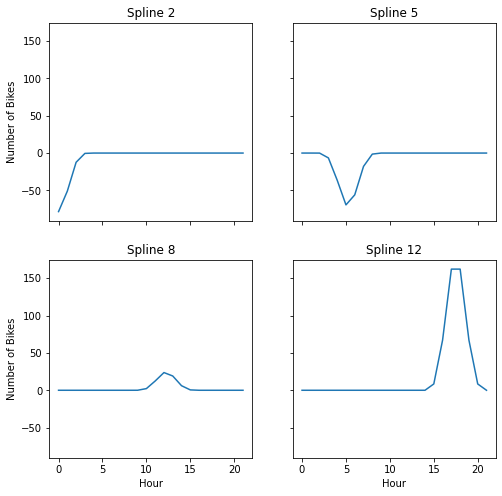

In [72]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize = (8,8),sharey=True, sharex=True)
(matrix*coefs)[1].plot(title = 'Spline 2', ax=ax[0,0])
(matrix*coefs)[4].plot(title = 'Spline 5', ax=ax[0,1])
(matrix*coefs)[8].plot(title = 'Spline 8', ax=ax[1,0])
(matrix*coefs)[11].plot(title = 'Spline 12', ax=ax[1,1])
plt.setp(ax[-1, :], xlabel='Hour')
plt.setp(ax[:, 0], ylabel='Number of Bikes')
plt.show()

In [1]:
#https://stackoverflow.com/questions/37379609/extract-knots-basis-coefficients-and-predictions-for-p-splines-in-adaptive-smo
#https://github.com/dswah/pyGAM/blob/master/pygam/pygam.py
#https://stackoverflow.com/questions/49570452/is-it-possible-to-specify-lower-bound-in-response-variable-during-smooth-with-ga